# Arrhenius Plotter

Zircon (U-Th)/He is a low-temperature (closure temperature: 180-200 C) thermochronometer. It is commonly used in tectonic settings to look at exhumation of rocks from ~4-6km depth. But how do we know *exactly* what the closure temperature is??

The Arrhenius equation, $\frac{D(T)}{a^{2}}$= $\frac{D_{0}}{a^{2}}$exp($\frac{E_{a}}{RT}$), governs helium diffusion in zircon where ${D(T)}$ is the zircon diffusivity, ${D_{0}}$ is the frequency factor, ${a^{2}}$ is the diffusion domain, $E_{a}$ is the activation energy, $R$ is the gas constant, and $T$ is the temperature step. By completing helium diffusion step-heating experiments, I determine zircon diffusivity $\frac{D(T)}{a^{2}}$, and activation energy ($E_a$).

I conducted cycled step-heating experiments on an ultra-high vacuum noble gas extraction and purification line for samples of zircon. Diffusion properties are constrained by measuring fractional helium release in controlled step-heating experiments using a quadrupole mass spectrometer. Each temperature step is 10C and incrementally steps from 300C to 600C in prograding and retrograding steps. Helium gas is analyzed after the temperature is held for 30 minutes in the initial prograde steps and 2.5 hours in the last retrograde steps.

**This notebook solves the diffusion equation out of sphere (a simplified zircon grain) and plots the diffusion experimental data. Then it calculates a closure temperature based on Dodson (1973) or a maximum temperature and event duration after Watson & Cherniak (2013).** 

## Import packages used in plotting and data reduction

In [1]:

from tkinter import *
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog as fd
from tkinter.messagebox import showinfo
from openpyxl import load_workbook
from itertools import islice
from pandas import *
import csv

filetypesTxt = (('csv files', '*.csv'),('All files', '*.*'))
filetypesXL = (('Excel files', '*.xlsx'),('All files', '*.*'))

class App(tk.Tk):
    def __init__(self):
        super().__init__()
        self.geometry("400x120")
        self.title('Arrhenius Plotter')

        # set up variable
        self.option_var = tk.StringVar(self)

        # create widget
        self.create_widgets()

    def ok(self):
        self.destroy()
   
    def select_APfile(self):
        global arren_param_filename
        arren_param_filename = fd.askopenfilename(title='Open a arrenhius parameters file',initialdir='C:/Users/malco/Catbird',filetypes=filetypesXL)
   
    def select_Samplefile(self):
        global df_sample_filename
        df_sample_filename = fd.askopenfilename(title='Open a sample file',initialdir='C:/Users/malco/Catbird',filetypes=filetypesXL)

    def create_widgets(self):
        # padding for widgets using the grid layout
        paddings = {'padx': 5, 'pady': 5}

        # open AP button
        open_APbutton = ttk.Button(self,text='Open the arrenhius parameters file',command=self.select_APfile)
        open_APbutton.grid(column=0, row=0, sticky=tk.W, **paddings)

        # open sample button
        open_Samplebutton = ttk.Button(self,text='Open the file with sample data from machine',command=self.select_Samplefile)
        open_Samplebutton.grid(column=0, row=1, sticky=tk.W, **paddings)

        #OK button
        button = Button(self, text="OK", command=self.ok)
        button.grid(column=2, row=3, sticky=tk.W, **paddings)

if __name__ == "__main__":
    app = App()
    app.mainloop()

class App2(tk.Tk):
    def __init__(self):
        super().__init__()
        self.geometry("300x70")
        self.title('Arrhenius Plotter window 2')
        self.samples=[]

        # initialize sample list from arrenius file
        wb = load_workbook(arren_param_filename)
        ws = wb.active
        line_count = 0
        for row in ws.iter_rows():
            line_count = line_count + 1
            if (line_count == 1):
                continue           #skip the first line because it contains headers
            if (ws['A'+str(line_count)].value is None):     #deal with the "none" case
                continue
            if (len(ws['A'+str(line_count)].value) > 4):    #make sure the sample name has at least 5 characters
                self.samples.append(ws['A'+str(line_count)].value)   #append it to the list
        wb.close()

        # set up variable
        self.option_var = tk.StringVar(self)

        # create widget
        self.create_widgets2()

    def option_changed(self, *args):
        global sample_name
        sample_name = self.option_var.get()
        
    def ok(self):
        self.destroy()
   
    def create_widgets2(self):
        # padding for widgets using the grid layout
        paddings = {'padx': 5, 'pady': 5}

        # option menu
        option_menu = ttk.OptionMenu(self,self.option_var,self.samples[0],*self.samples,command=self.option_changed)
        option_menu.grid(column=1, row=0, sticky=tk.W, **paddings)

        # label
        label = ttk.Label(self,  text='Select your sample:')
        label.grid(column=0, row=0, sticky=tk.W, **paddings)

        #OK button
        button = Button(self, text="OK", command=self.ok)
        button.grid(column=2, row=3, sticky=tk.W, **paddings)

if __name__ == "__main__":
    app2 = App2()
    app2.mainloop()




NameError: name 'arren_param_filename' is not defined

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from scipy import stats
%matplotlib inline

## Add csv file from Instrument

In [2]:
df_sample = pd.read_excel('18ries01-3_ginster_test_new2022.xlsx')
arren_param = pd.read_excel('arrenhius_parameters.xlsx')
df_sample.columns = df_sample.iloc[3]
df_sample.drop(df_sample.index[0])
df_sample = df_sample.drop(range(0,4))
df_sample = df_sample.drop(range(4,6))
df_sample.drop(df_sample.tail(2).index,inplace=True)
df_sample=df_sample.dropna(how='all')
df_sample = df_sample.iloc[:, :-4]
df_sample = df_sample.astype(float)
print(list(df_sample))
df_sample

['Step', 't cum, h', 'T', 'δ(Tn)(1σ)', '104/T', 'σ (104/Tn)', 'Δtn', 'Δtn', 'δΔtn (1σ)', 'Xn', 'δXn (1σ)', 'RSD', 'Xn/XT', 'Xn/XT (1δ)', 'RSD', 'f(n)', 'δf(n) (1σ)', 'RSD', '(D/a2)n', 'δ(D/a2)(Δtn)', 'δ(D/a2)(Xi)', 'δ(D/a2)(1σ)', 'RSD', '2σ', 'ln(D/a²)n', 'δ(ln(D/a²))(1σ)', 'RSD', 'ln(D/a²)n 2σ', 'Dn', '1σ', 'Rel. 1σ', '2σ']


3,Step,"t cum, h",T,δ(Tn)(1σ),104/T,σ (104/Tn),Δtn,Δtn,δΔtn (1σ),Xn,...,RSD,2σ,ln(D/a²)n,δ(ln(D/a²))(1σ),RSD,ln(D/a²)n 2σ,Dn,1σ,Rel. 1σ,2σ
6,1.0,1.000000,250.01,0.39,19.114611,0.013720,1.000000,3600.0,30.0,0.02825,...,113.299872,3.732920e-11,-24.829260,1.132999,4.563159,2.265997,2.125915e-15,2.409822e-15,113.354574,4.819644e-15
7,2.0,2.000000,260.01,0.37,18.756096,0.012541,1.000000,3600.0,30.0,0.02344,...,143.570507,1.111197e-10,-23.975216,1.435705,5.988288,2.871410,4.994048e-15,7.172135e-15,143.613679,1.434427e-14
8,3.0,3.000000,270.01,0.35,18.410781,0.011438,1.000000,3600.0,30.0,0.02502,...,97.592580,1.295721e-10,-23.435562,0.975926,4.164294,1.951852,8.566855e-15,8.366055e-15,97.656080,1.673211e-14
9,4.0,4.000000,280.01,0.41,18.077952,0.012928,1.000000,3600.0,30.0,0.02757,...,88.181550,1.819586e-10,-22.994617,0.881815,3.834878,1.763631,1.331440e-14,1.175020e-14,88.251822,2.350040e-14
10,5.0,5.000000,290.01,0.38,17.756943,0.011567,1.000000,3600.0,30.0,0.03148,...,60.194606,1.882236e-10,-22.578950,0.601946,2.665961,1.203892,2.017637e-14,1.216585e-14,60.297503,2.433170e-14
11,6.0,6.000000,300.01,0.38,17.447135,0.011174,1.000000,3600.0,30.0,0.03519,...,69.026574,3.085279e-10,-22.221677,0.690266,3.106272,1.380531,2.884064e-14,1.993359e-14,69.116324,3.986718e-14
12,7.0,7.000000,310.01,0.35,17.147953,0.009948,1.000000,3600.0,30.0,0.03918,...,77.117147,4.772373e-10,-21.896310,0.771171,3.521924,1.542343,3.993099e-14,3.082572e-14,77.197492,6.165144e-14
13,8.0,8.000000,320.01,0.44,16.858858,0.012094,1.000000,3600.0,30.0,0.04660,...,54.593537,4.927732e-10,-21.518865,0.545935,2.537008,1.091871,5.824149e-14,3.186216e-14,54.706971,6.372431e-14
14,9.0,9.000000,330.01,0.43,16.579349,0.011437,1.000000,3600.0,30.0,0.05579,...,62.351649,8.225365e-10,-21.139395,0.623516,2.949547,1.247033,8.512045e-14,5.315856e-14,62.450992,1.063171e-13
15,10.0,10.000000,340.01,0.39,16.308957,0.010043,1.000000,3600.0,30.0,0.06890,...,44.065676,8.764310e-10,-20.728821,0.440657,2.125817,0.881314,1.283347e-13,5.673179e-14,44.206132,1.134636e-13


Stored 'ries01_3' (Series)


6      0.008949
7      0.015215
8      0.024235
9      0.036695
10     0.053261
11     0.076142
12     0.106841
13     0.143745
14     0.190683
15     0.247456
16     0.318020
17     0.404499
18     0.506242
19     0.635339
20     0.762706
21     0.953239
22     1.194399
23     1.500734
24     1.839131
25     2.283596
26     2.782110
27     3.407385
28     4.141994
29     5.039043
30     6.033120
31     7.260872
32     8.855039
33    10.485175
34    11.453119
35    11.968113
36    12.432515
37    12.770075
38    13.279894
39    12.240121
40    11.808582
41    11.319701
42    11.183751
43    11.427173
44    11.531772
45    11.538675
46    13.250849
47    14.222233
48    14.648363
49    14.987126
50    15.914224
51    16.841579
52    17.868230
53    18.486547
54    19.907144
55    22.462483
56    27.356436
57    31.452140
58    37.818940
59    46.325698
60    57.812308
61    73.524116
Name: weighted gas count, dtype: float64

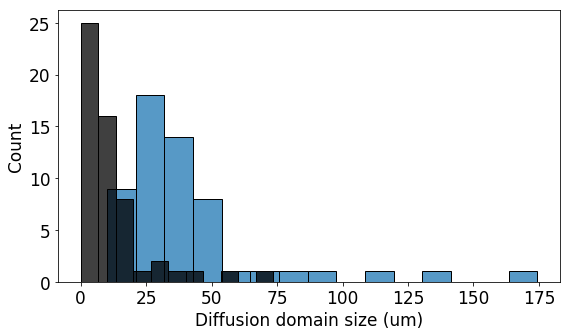

In [7]:
df_sample['intercept']=df_sample['ln(D/a²)n']-df_sample['104/T']*-1.9725
df_sample['a um']=np.sqrt(.000046/np.exp(df_sample['intercept']))*1000000
df_sample['weighted gas count']=df_sample['f(n)']*df_sample['a um']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size']=17
fig, ax = plt.subplots(figsize=(9,5))
sns.histplot(df_sample['a um']) 
sns.histplot(df_sample['weighted gas count'], color="black") 


plt.xlabel('Diffusion domain size (um)')
plt.savefig('18ries1-3.pdf', transparent=True);

ries01_3=df_sample['a um']
ries01_3w=df_sample['weighted gas count']
%store ries01_3
%store ries01_3w

## Plot methods figure 

This cell calculated the cumulative sum of the seconds of each step of the experiment then converts sec to hrs.

The second cell in this block shows the prograde and retrograde steps aka Temperature vs time of the experiment. On the second axis it shows the raw data aka how much helium was released in each step. It also saves the figure. 

In [4]:
#df_sample['Time elapsed (s)']=(df_sample['Total s'].cumsum())
#df_sample['Time elapsed (hrs)']=(df_sample['Time elapsed (s)'])/3600


NameError: name 'sample_name' is not defined

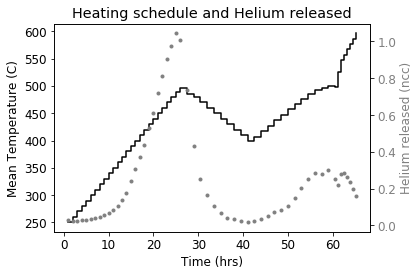

In [5]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size']=12

fig, ax1 = plt.subplots()
ax1.set_xlabel("Time (hrs)")
ax1.set_ylabel("Mean Temperature (C)", color='black')
plt.step(df_sample['t cum, h'], df_sample['T'], where='post', color='black', label= "Temperature steps")
ax1.tick_params(axis='y',labelcolor='black')
ax2 = ax1.twinx()
ax2.set_ylabel('Helium released (ncc)', color='gray')  # we already handled the x-label with ax1
plt.plot(df_sample['t cum, h'], df_sample['Xn'], 'o', color='gray', markersize=3.0, label= "Helium released")
ax2.tick_params(axis='y', labelcolor='gray')
plt.title('Heating schedule and Helium released')

fig.tight_layout()  

plt.savefig('heating_sched_He_release_'+sample_name+'.pdf')


## Set up subset of data wanted for linear regression
Calculate slope (activation energy) and y-intercept (Frequency factor)

Iterative with the next cell - plot data then figure out what subset of the data you want to fit a line through.

In [5]:
subset=df_sample.iloc[0:5,:] #this is were you can change subset of the data
x=subset['104/T']
y=subset['ln(D/a²)n']
slope, intercept, r_value, p_value, std_err=stats.linregress(x, y) #regress line through data
xmin = np.min(x)
xmax = np.max(x)
xi = np.array([xmin,xmax]) 
yi = xi*slope + intercept
print('slope {0:6.2f}, intercept {1:6.2f}'.format(slope,intercept))
print('correlation coefficient {0:6.3f}, p value {1:8.5f}'.format(r_value, p_value))
p, V = np.polyfit(x, y, 1, cov=True)
slope_error=np.sqrt(V[0][0])
intercept_error=np.sqrt(V[1][1])
print("slope: {} +/- {}".format(p[0], np.sqrt(V[0][0])))
print("intercept: {} +/- {}".format(p[1], np.sqrt(V[1][1])))

slope  -1.62, intercept   6.28
correlation coefficient -0.991, p value  0.00111
slope: -1.6197801178395714 +/- 0.224744745968529
intercept: 6.2789362285428885 +/- 4.141939861751514


In [6]:
subset2=df_sample.iloc[10:26,:] #this is were you can change subset of the data
x1=subset2['104/T']
y1=subset2['ln(D/a²)n']
slope2, intercept2, r_value2, p_value2, std_err2=stats.linregress(x1, y1) #regress line through data
xmin1 = np.min(x1)
xmax1 = np.max(x1)
xi1 = np.array([xmin1,xmax1]) 
yi1 = xi1*slope2 + intercept2
print('slope {0:6.2f}, intercept {1:6.2f}'.format(slope2,intercept2))
print('correlation coefficient {0:6.3f}, p value {1:8.5f}'.format(r_value2, p_value2))
p, V = np.polyfit(x1, y1, 1, cov=True)
slope_error2=np.sqrt(V[0][0])
intercept_error2=np.sqrt(V[1][1])
print("slope: {} +/- {}".format(p[0], np.sqrt(V[0][0])))
print("intercept: {} +/- {}".format(p[1], np.sqrt(V[1][1])))

slope  -1.91, intercept  10.42
correlation coefficient -0.998, p value  0.00000
slope: -1.912194468809616 +/- 0.030947277954786856
intercept: 10.41771538972089 +/- 0.4463450946980198


In [7]:
subset3=df_sample.iloc[27:49,:] #this is were you can change subset of the data
x3=subset3['104/T']
y3=subset3['ln(D/a²)n']
slope3, intercept3, r_value3, p_value3, std_err2=stats.linregress(x3, y3) #regress line through data
xmin3 = np.min(x3)
xmax3 = np.max(x3)
xi3 = np.array([xmin3,xmax3]) 
yi3 = xi3*slope3 + intercept3
print('slope {0:6.2f}, intercept {1:6.2f}'.format(slope3,intercept3))
print('correlation coefficient {0:6.3f}, p value {1:8.5f}'.format(r_value3, p_value3))
p, V = np.polyfit(x3, y3, 1, cov=True)
slope_error3=np.sqrt(V[0][0])
intercept_error3=np.sqrt(V[1][1])
print("slope: {} +/- {}".format(p[0], np.sqrt(V[0][0])))
print("intercept: {} +/- {}".format(p[1], np.sqrt(V[1][1])))

slope  -1.66, intercept   5.83
correlation coefficient -0.988, p value  0.00000
slope: -1.6558902318946596 +/- 0.060570983308067546
intercept: 5.82622382811851 +/- 0.8363887339512539


In [8]:
wb = load_workbook(arren_param_filename)
ws = wb.active
i=0
for row in ws.iter_rows():
    i=i+1
    for cell in row:
        if 'A' in cell.coordinate:
            if cell.value == sample_name:
                ws['D'+str(i)].value = slope
                ws['E'+str(i)].value = slope_error
                ws['F'+str(i)].value = intercept
                ws['G'+str(i)].value = intercept_error
                ws['H'+str(i)].value = slope2
                ws['I'+str(i)].value = slope_error2
                ws['J'+str(i)].value = intercept2
                ws['K'+str(i)].value = intercept_error2
                ws['L'+str(i)].value = slope3
                ws['M'+str(i)].value = slope_error3
                ws['N'+str(i)].value = intercept3
                ws['O'+str(i)].value = intercept_error3
wb.save(arren_param_filename)
wb.close()

## Plot diffusion figure
Plots all experimental data - You may need to iterate between cell above and this cell to find the right subset of data to calculate slope and y-intercept. 

The colormap shows how much cumulative gas has been released so far in the experiment. 

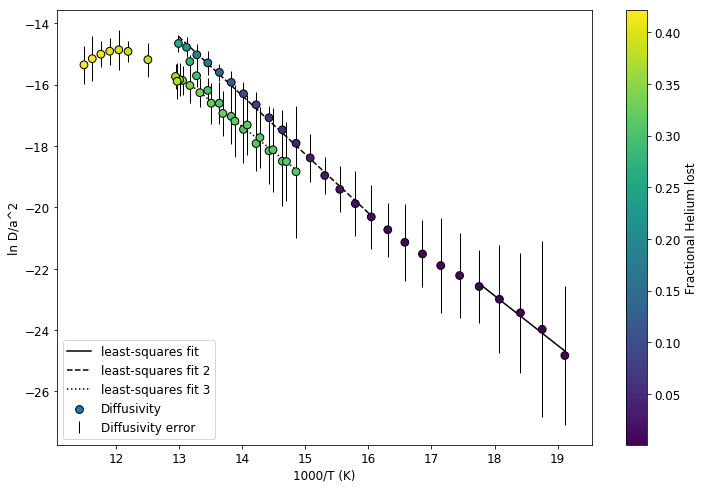

In [9]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size']=12
t=df_sample['f(n)']
scatter_kwargs = {"zorder":100}
error_kwargs = {"lw":.5, "zorder":0}
#plot error bars from that column in dataframe
#then plot the calculated measurement
#then plot regressed line
#colorbar based on fractional loss
fig=plt.figure(figsize=(12,8))
plt.errorbar(df_sample['104/T'], df_sample['ln(D/a²)n'],yerr=df_sample['ln(D/a²)n 2σ'],elinewidth=1, fmt='None',marker="None", ecolor='black', label='Diffusivity error', mew=0,**error_kwargs)
plt.scatter(df_sample['104/T'], df_sample['ln(D/a²)n'],c=t, cmap='viridis',s=60, edgecolors='black',label='Diffusivity', **scatter_kwargs)
plt.plot(xi, yi, c='black', label = 'least-squares fit')
plt.plot(xi1, yi1, c='black',linestyle='dashed', label = 'least-squares fit 2')
plt.plot(xi3, yi3, c='black',linestyle='dotted', label = 'least-squares fit 3')
plt.xlabel('1000/T (K)')
plt.ylabel('ln D/a^2')
plt.legend(loc='lower left')
cb = plt.colorbar()
cb.set_label('Fractional Helium lost', fontsize=12)

#secax = ax.secondary_xaxis('top', df_sample['SP)'])
#secax.set_xlabel('Temperature [s]')

plt.savefig('ArrenhiusPlot'+sample_name+'ginster_ncc.pdf', transparent=True);

### Closure Temperature calculations - Dodson 1973
This should be between 180 -200 C for Zircon.

We have to assume a tectonic cooling rate, commonly 10 C/Ma.

Function iterates through to calculate a closure temperature - it should level off as it gets closer to the right calculation. We have to iterate through because Tc is also a dependent variable.


In [43]:
coolrate=10 #10 degrees C/Ma
coolrate1=coolrate/((10**6)*365*24*60*60) #Dt/dt (deg/s)
a=51.4 #spherical radius
R=0.0083144621 #KJ/(molK)
Ea1=(-10000*slope*R) #cal/mol 
Ea_error1=(-10000*slope_error*R)
Doa2_1=np.exp(intercept)
Do1=Doa2_1*((a*10**-4)**2)
Do_error1=Doa2_1*intercept_error

Ea2=(-10000*slope2*R) #cal/mol 
Ea_error2=(-10000*slope_error2*R)
Doa2_2=np.exp(intercept2)
Do2=Doa2_2*((a*10**-4)**2)
Do_error2=Doa2_2*intercept_error2

Ea3=(-10000*slope3*R) #cal/mol 
Ea_error3=(-10000*slope_error3*R)
Doa2_3=np.exp(intercept3)
Do3=Doa2_3*((a*10**-4)**2)
Do_error3=Doa2_3*intercept_error3



Tc_start=180+273.15 #first guess of Tc to start iteration


In [44]:
def close (test): 
    for i in range (1,50): 
        test=(Ea1/R)/(np.log((a*R*(test**2)*Do1)/(Ea1*coolrate1)))   
    return (test)
def close2 (test): 
    for i in range (1,50): 
        test=(Ea2/R)/(np.log((a*R*(test**2)*Do2)/(Ea2*coolrate1)))   
    return (test)
def close3 (test): 
    for i in range (1,50): 
        test=(Ea3/R)/(np.log((a*R*(test**2)*Do3)/(Ea3*coolrate1)))   
    return (test)

In [45]:
closuretemp1=close(Tc_start)-273.15
closuretemp2=close2(Tc_start)-273.15
closuretemp3=close3(Tc_start)-273.15
print('The calculated closure temperature for first is: {0:6.2f} degrees Celsius'.format(closuretemp1))
print('The calculated closure temperature for second is: {0:6.2f} degrees Celsius'.format(closuretemp2))
print('The calculated closure temperature for third is: {0:6.2f} degrees Celsius'.format(closuretemp3))
data = {
    'iodp364-93-10': [Do1, Do_error1, Ea1,Ea_error1,Do2, Do_error2, Ea2,Ea_error2,closuretemp1, closuretemp2,a],
'sample name':['Do1', 'Do_error1', 'Ea1','Ea_error1','Do2', 'Do_error2', 'Ea2','Ea_error2','closuretemp1', 'closuretemp2','a']}
g = pd.DataFrame(data)
g.to_csv('arrenhius_parameters.csv', mode='w', index=False, header=True)


The calculated closure temperature for first is: 220.35 degrees Celsius
The calculated closure temperature for second is: 251.33 degrees Celsius
The calculated closure temperature for third is: 239.99 degrees Celsius


### Cherniak Watson 2013 Calculations
The following cells calculate a duration range of durations based off temperature ranges and using the data (Ea and Do -slope and y-intercept) from the experiment. There are three lines showing what happens if the diffusion domain is reduced. The boxes are common contact, excavation, and hydrothermal temperatures and durations from Young et al. 2013 and references therein.

In [41]:
R=8.314#0.008314 #kj/mol*K 
Ea=(-10000*slope*R) #kJ/mol 
Do=1/np.e**(intercept) #m2/s
#dur = np.arange(100,13000,100)
Tmax = np.arange(150,17000,100) #k

frac=0.99
#frac=np.log(Do*dur/a**2)+(140/Tmax)-(0.437*Ea/(R*Tmax))-0.8
a=5*(10**(-5)) #diffusion radius #um
a1=5*(10**(-7))
a2=5*(10**(-6))
dur=(a**2*np.e**(4/5 + (-140 + (437*Ea)/(1000*R))/Tmax)*frac)/Do
dur1=(a1**2*np.e**(4/5 + (-140 + (437*Ea)/(1000*R))/Tmax)*frac)/Do
dur2=(a2**2*np.e**(4/5 + (-140 + (437*Ea)/(1000*R))/Tmax)*frac)/Do

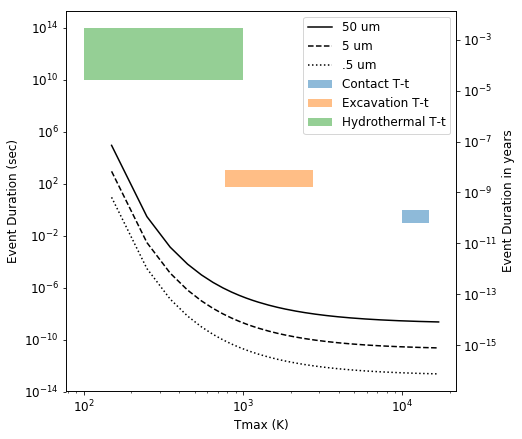

In [42]:

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size']=12
fig, ax1 = plt.subplots(figsize=(7,7))
ax1.set_xlabel('Tmax (K)')
ax1.set_ylabel('Event Duration (sec)', color='black')
ax1.loglog(Tmax,dur,'-k', label = '50 um')
ax1.loglog(Tmax,dur2,'--k', label= '5 um')
ax1.loglog(Tmax,dur1,':k',label='.5 um')


coord_cont=[[10**4,10**-1],[10**4,10**0],[10**4.17,10**0],[10**4.17,10**-1]]
coord_hydro=[[10**2,10**14],[10**2,10**10],[10**3,10**10],[10**3,10**14]]
coord_exca=[[10**2.888,10**3.079],[10**2.888,10**1.77],[10**3.44,10**1.77],[10**3.44,10**3.079]]

xs, ys= zip(*coord_cont) #create lists of x and y values
plt.fill(xs, ys,alpha=0.5, label= 'Contact T-t')
xs1, ys1= zip(*coord_exca) #create lists of x and y values
plt.fill(xs1, ys1,alpha=0.5,label='Excavation T-t')
xs2, ys2= zip(*coord_hydro) #create lists of x and y values
plt.fill(xs2, ys2,alpha=0.5, label= 'Hydrothermal T-t') 

plt.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.set_ylabel('Event Duration in years')
plt.loglog(Tmax,dur/31536000, alpha=0.0)
ax2.tick_params(axis='y')


#plt.savefig('ParabolicTt_Cherniak_Duration_Temp18RIES01-09.pdf')

### Save dataframe as csv for safekeeping  

In [ ]:
#df_sample.to_csv('ArrenhiusCalculations18Ries04-13.csv', index=False)